In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm, tqdm_pandas
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import nltk
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy.stats import skew
from tqdm import tqdm, tqdm_pandas
tqdm_pandas(tqdm())
from collections import Counter
import itertools


0it [00:00, ?it/s]


In [2]:
# Load in data
column_names = ['ID', 'Title', 'From', 'To', 'House', 'Term', 'Session', 'Meeting',
       'Sitting', 'Agenda', 'Subcorpus', 'Speaker_role', 'Speaker_type',
       'Speaker_party', 'Speaker_party_name', 'Party_status', 'Speaker_name',
       'Speaker_gender', 'Speaker_birth', "Text"]
ParlaMint = pd.read_csv("data/parlamint.csv", index_col=False, usecols = column_names)
ParlaMint.drop(columns = ["Session", "Meeting", "Sitting", "Agenda", "Party_status", "Speaker_birth"], inplace = True)

### Sentiment analysis

**Probably needs to write some text to glue the parts together here!**

For the basis of the sentiment analysis of the speeches in parliament, a dictionary-based sentiment analysis was applied. Here a predefined dictionary with happiness scores associated with the 10222 most commonly used words in the English dictionary is used to explore if sentiment analysis can highlight any underlying structures of the British parliament.

Firstly the Hedonmeter file containing the happiness scores is loaded in.

In [3]:
# Load in Hedonmeter
labMT = pd.read_csv("../Week_7/Hedonometer.csv")
labMT.head()

,Rank,Word,Word in English,Happiness Score,Standard Deviation of Ratings
0,0,laughter,laughter,8.50,0.93
1,1,happiness,happiness,8.44,0.97
2,2,love,love,8.42,1.11
3,3,happy,happy,8.30,0.99
4,4,laughed,laughed,8.26,1.16


To see the distribution of happiness scores a histogram is used.

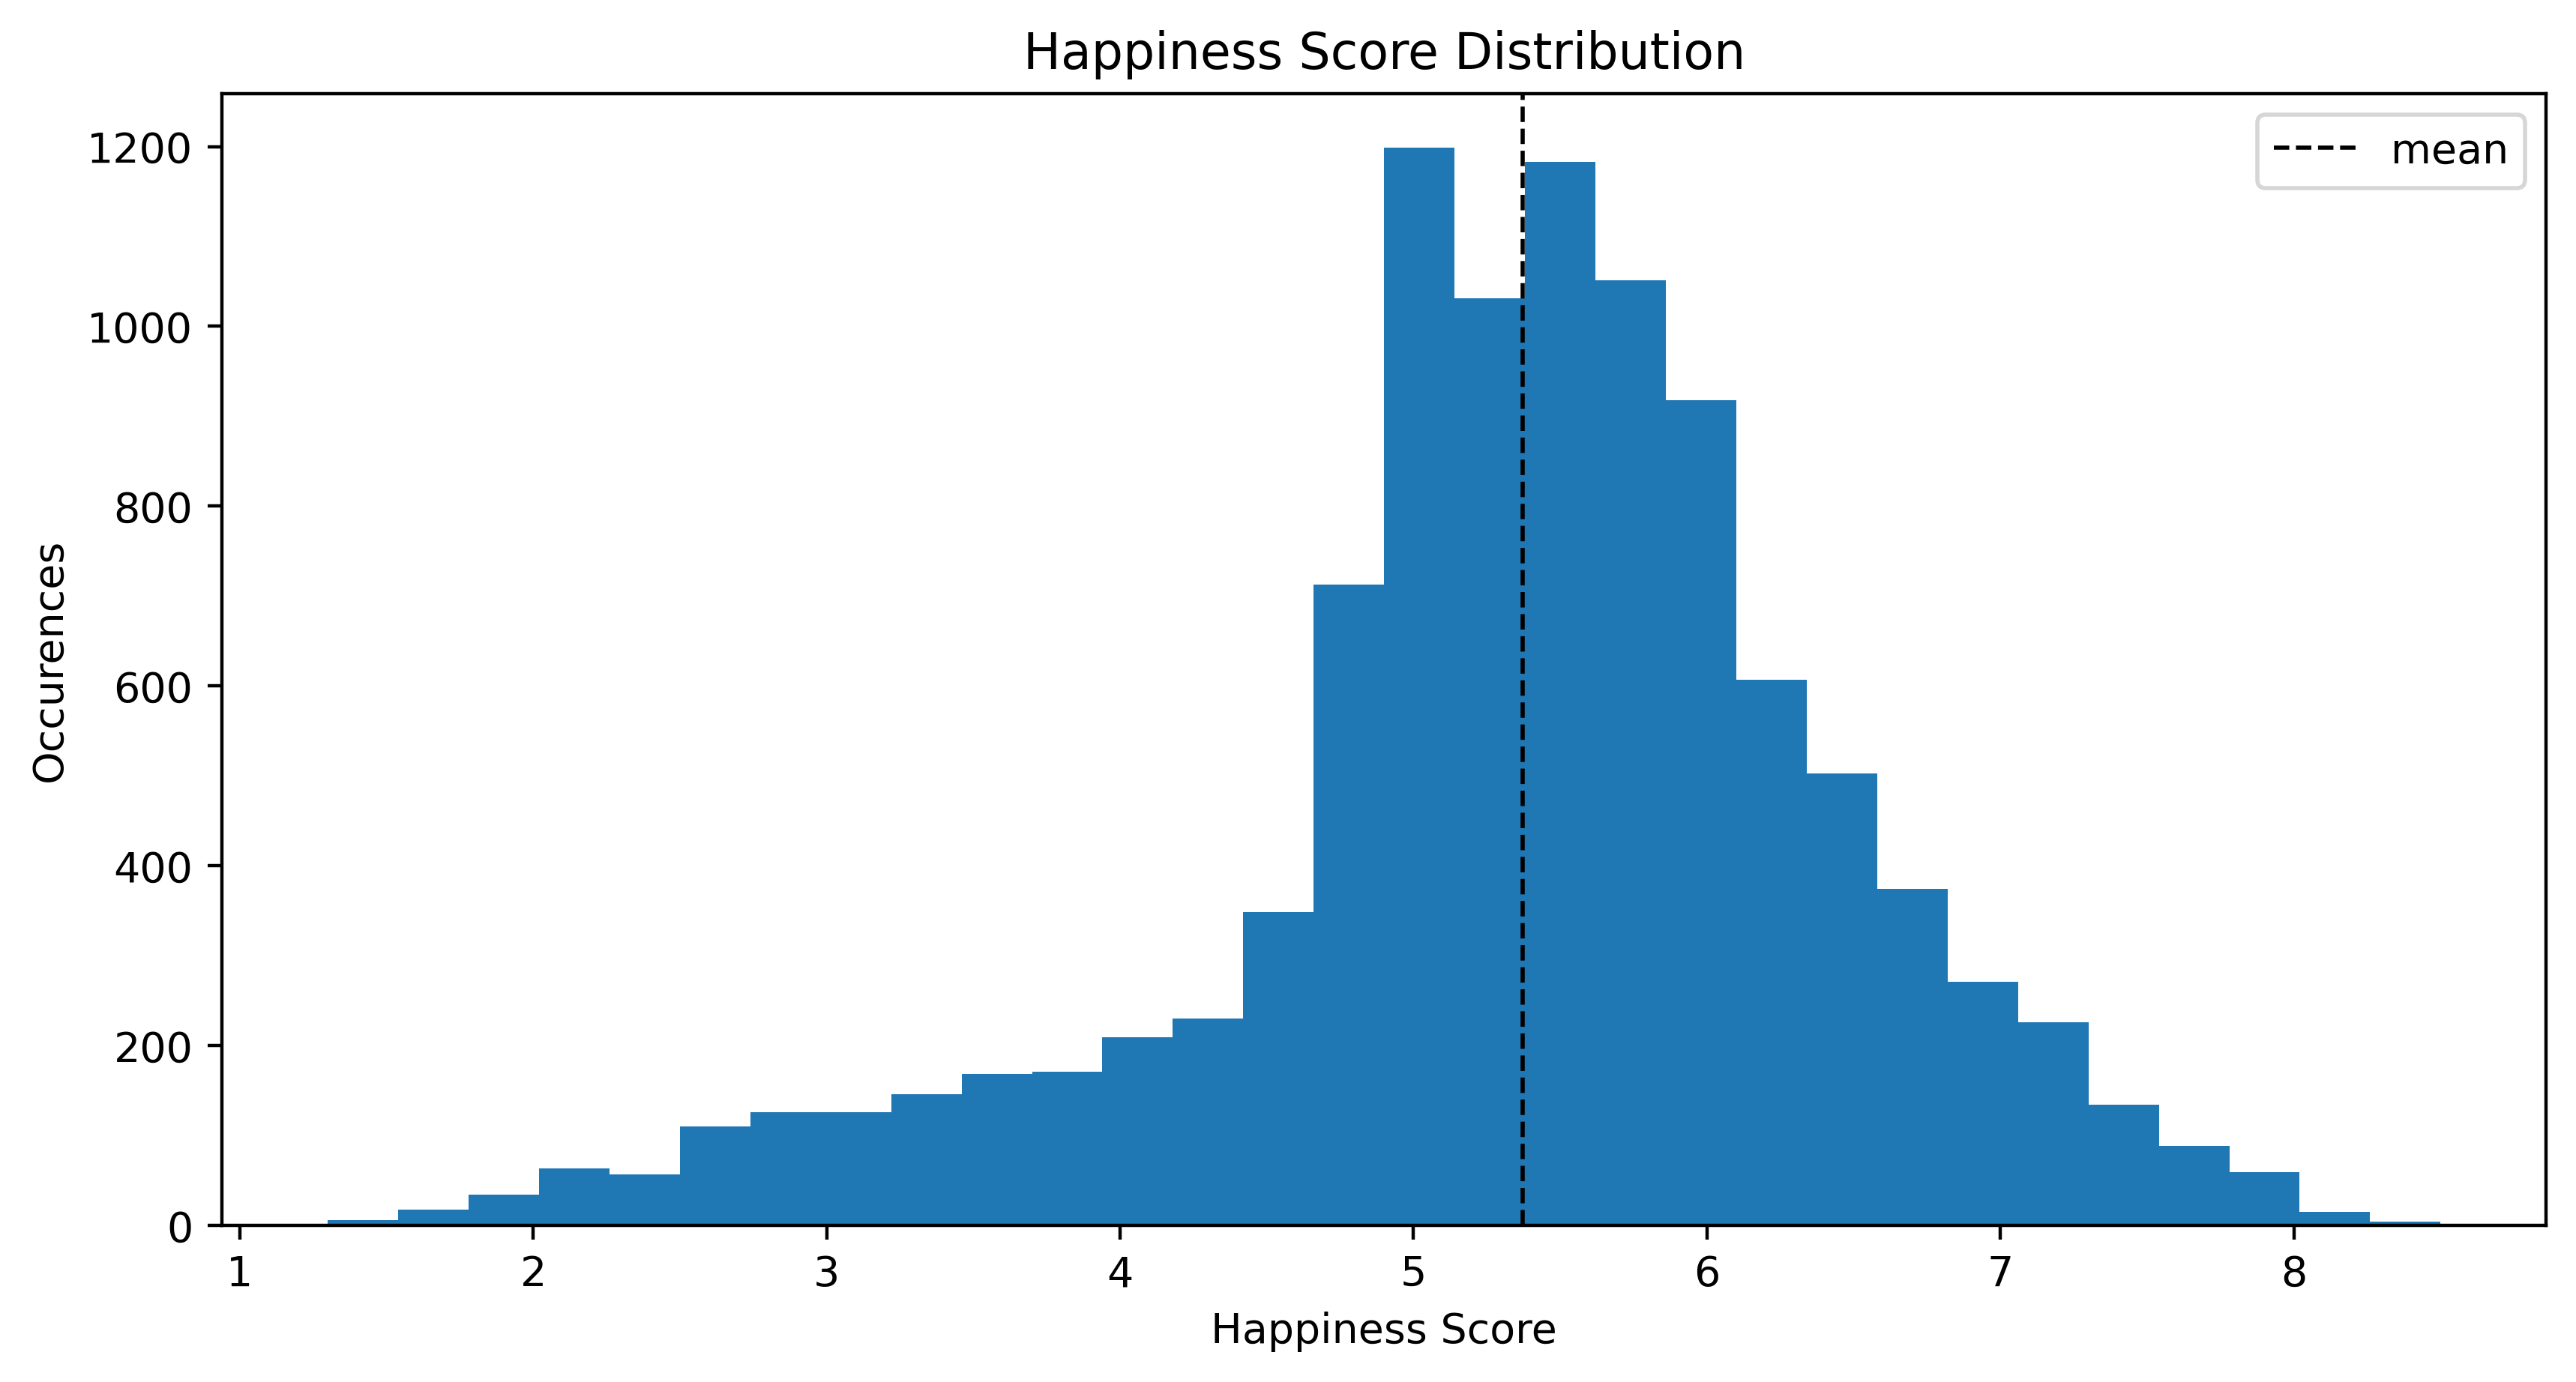

In [4]:
fig, ax = plt.subplots(figsize=(10,5), dpi = 400)
ax.hist(labMT["Happiness Score"].values, bins=30)
ax.axvline(labMT["Happiness Score"].mean(), color='k', linestyle='dashed', linewidth=1, label="mean")
ax.set_title("Happiness Score Distribution")
ax.set_xlabel("Happiness Score")
ax.set_ylabel("Occurences")
ax.legend()
plt.show()

In [5]:
print(f'skewness of happiness scores: {skew(labMT["Happiness Score"].values)}')

skewness of happiness scores: -0.6087457806147994


The skewness measure indicate that the distribution have a moderately skewness to it. More specifically it shows that the distribution have a right sided tail. 

Next step is the creation of two function:

The first function *find_the_happiness* is based upon the formula: 
$$h_{avg}(T)=\sum_{i=1}^{N}h_{avg}(w_i)p_i$$
where $p_i = \frac{f_i}{\sum_{j=1}^{N}f_j}$ and $f_i$ is the frequency of the i'th word $w_i$.

The second function *preprocess* takes a text string as input and tokenizes it, filtering out stop words and punctuation. 

In [6]:
def find_the_happiness(tokens, happiness_df):
    # Initialize happiness
    avg_happiness = 0
    tokens = [word.lower() for word in set(tokens) if word.isalpha() and word in labMT["Word"].values]
    fdist = nltk.FreqDist(tokens)
    N = len(tokens)
    for token in tokens:
        p = fdist[token] / N
        avg_happiness += happiness_df['Happiness Score'][happiness_df['Word'] == token].item() * p
    return avg_happiness

def preprocess(text):
    #Common english stop words
    stop_words = set(stopwords.words('english'))
    #Tokenize using nltk
    word_tokens = word_tokenize(text.lower())
    #removing none letter characters and stop words
    filtered_sentence = [word for word in word_tokens if word not in stop_words and word.isalpha()]
    return filtered_sentence

In the following steps the data is tokenized.

In [7]:
ParlaMint["tokens"] = ParlaMint["Text"].progress_apply(lambda x: preprocess(x))

552103it [12:02, 764.33it/s] 


In [8]:
# Create new column in datetime.date format based on the "From" column.
ParlaMint["date"] = ParlaMint["From"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").date())

Since the data column describing if each speaker is a member of the coalition or opposition is filtered out the initial sentimental analysis is done on the two major parties from the coalition and the opposition. Namely the Labour party and the Conservative party.

In [9]:
labour_df = ParlaMint[ParlaMint["Speaker_party_name"] == "Labour"]
conservative_df = ParlaMint[ParlaMint["Speaker_party_name"] == "Conservative"]

In [10]:
token_pr_date_labour = labour_df.groupby("date").tokens.sum()
token_pr_date_conservative = conservative_df.groupby("date").tokens.sum()

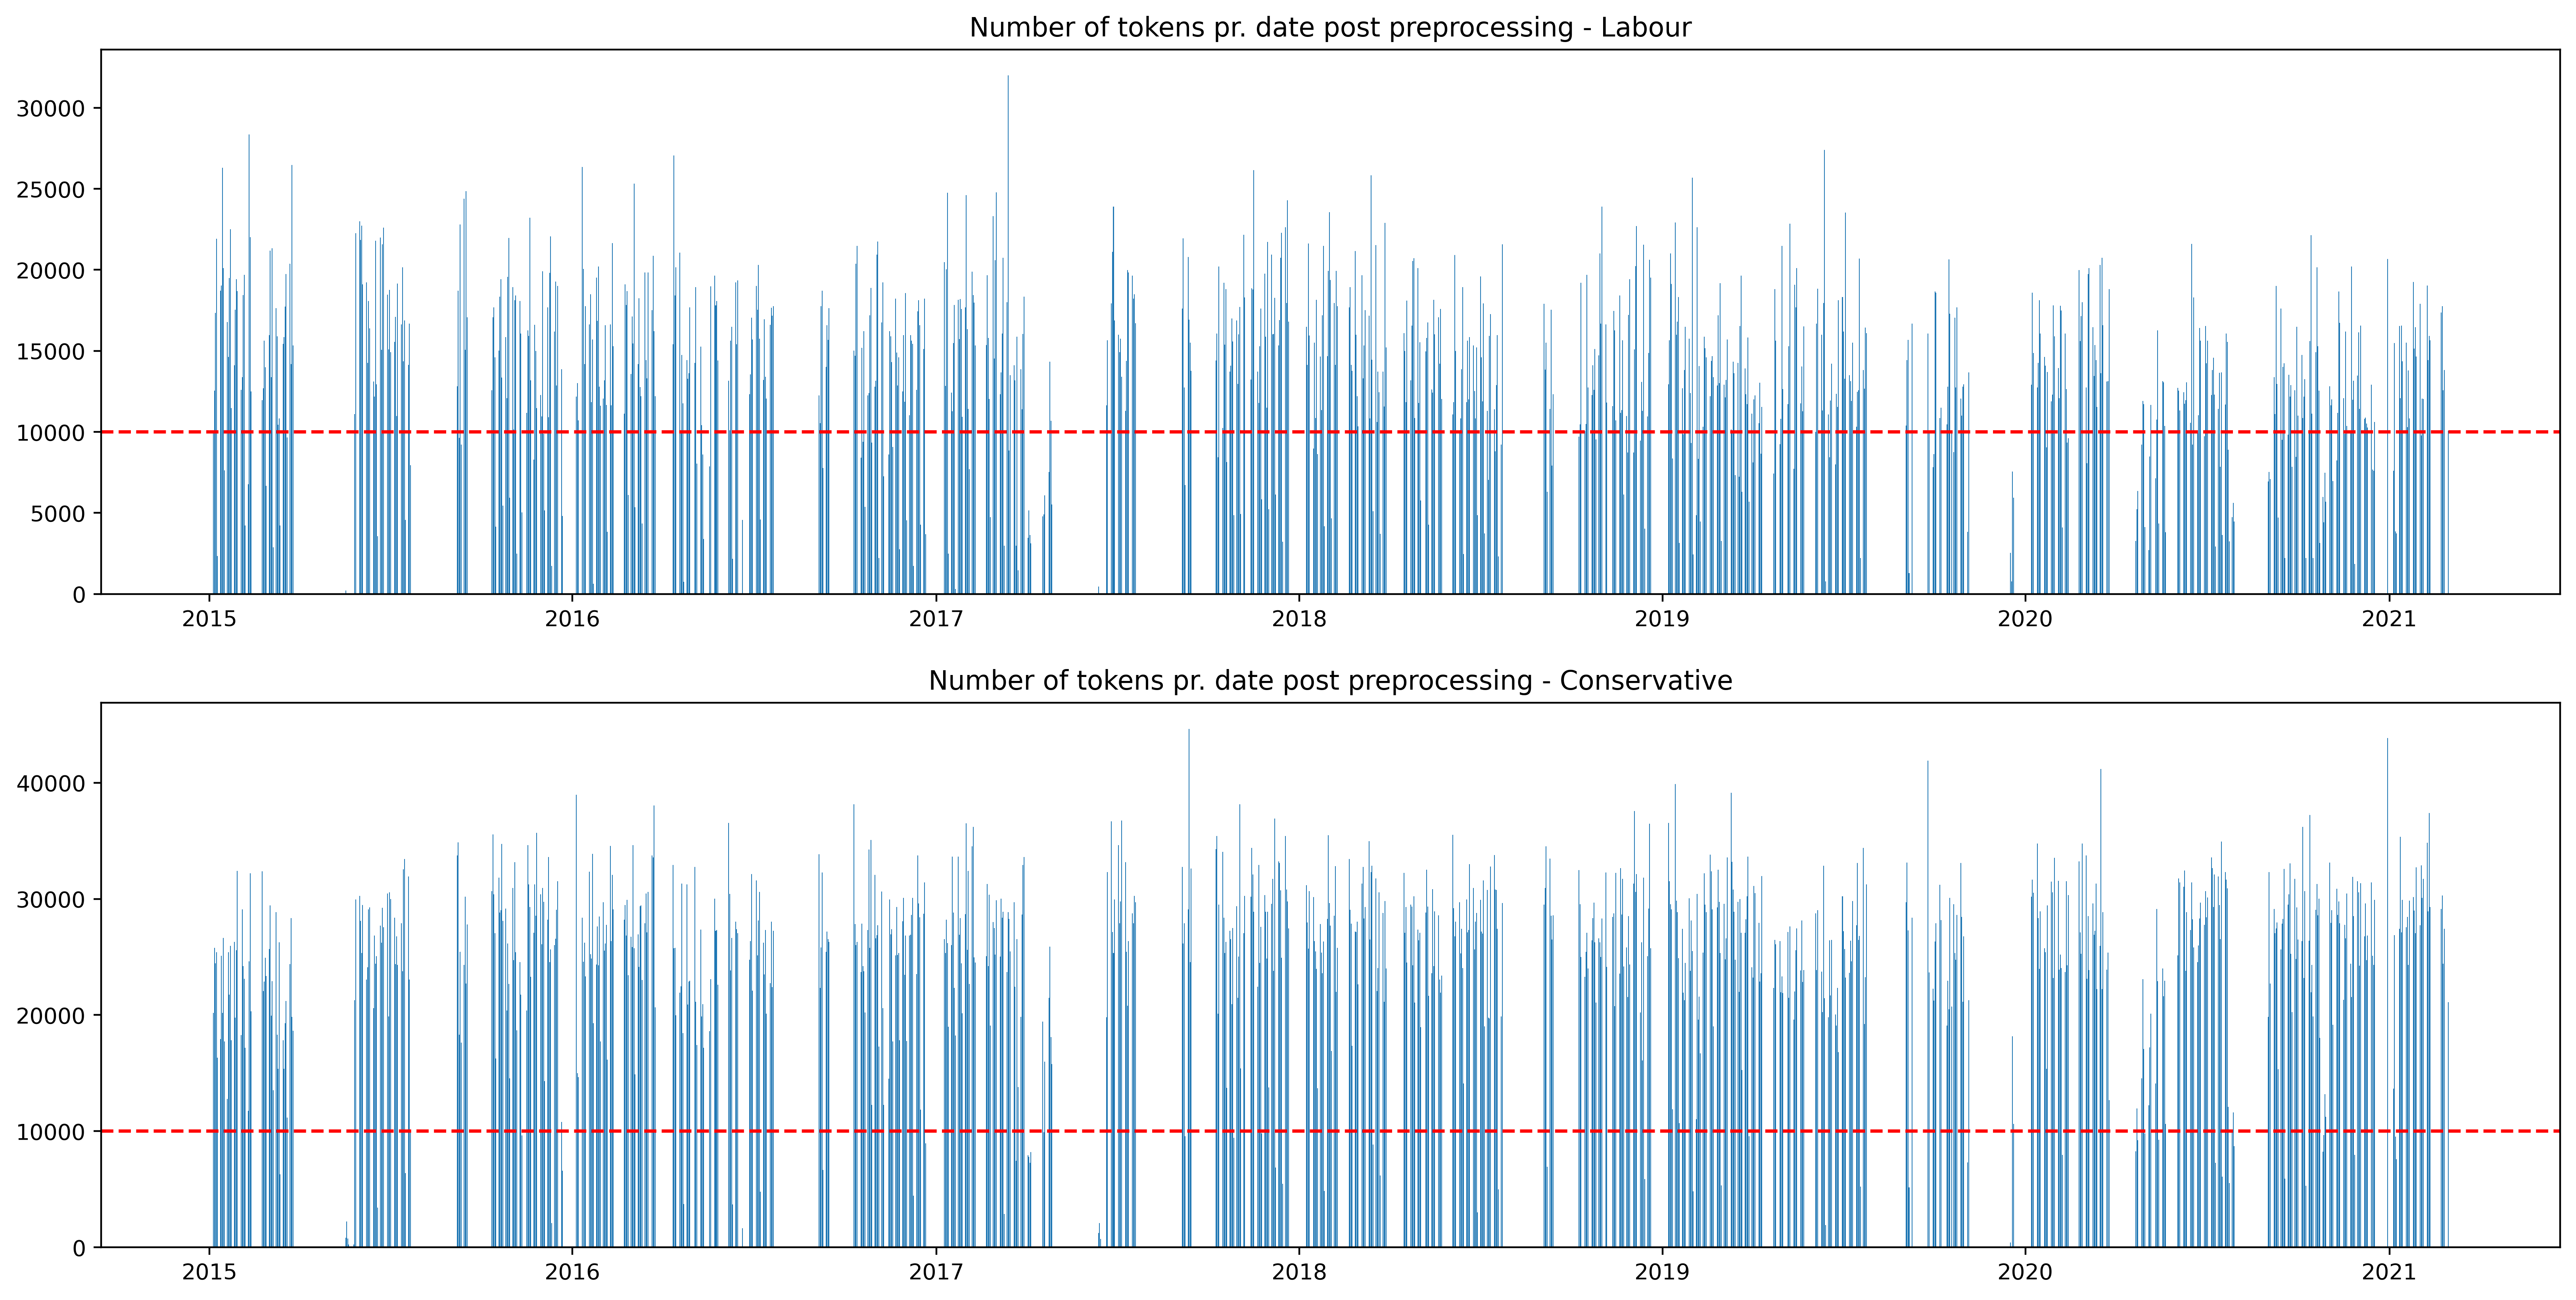

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10), dpi=400)
ax1.bar(token_pr_date_labour.index, [len(x) for x in token_pr_date_labour])
ax1.set_title("Number of tokens pr. date post preprocessing - Labour")
# Add some labels
ax1.axhline(10000, linestyle = "--", color = "r")

ax2.bar(token_pr_date_conservative.index, [len(x) for x in token_pr_date_conservative])
ax2.set_title("Number of tokens pr. date post preprocessing - Conservative")
# Add some labels
ax2.axhline(10000, linestyle = "--", color = "r")

plt.show()

Since dictionary based methods need a large document size to work properly, it is seen from the above plot that especially the Labour document is on the limit of wheather the sentiment analysis yields a reliable result. With the Conservative document only a few days are below the recommended token size of 10000 words. This also reflect that over the entire period of the dataset, Conservative is the larger party.

In [13]:
labour_avg_token = np.mean([len(x) for x in token_pr_date_labour])
conservative_avg_token = np.mean([len(x) for x in token_pr_date_conservative])
print(f"Mean number for token pr date for Labour: {labour_avg_token}")
print(f"Mean number for token pr date for Conservative: {conservative_avg_token}")

Mean number for token pr date for Labour: 13827.087460484721
Mean number for token pr date for Conservative: 25141.098532494758


In [14]:
token_pr_date_labour = token_pr_date_labour.to_frame()
token_pr_date_conservative = token_pr_date_conservative.to_frame()
token_pr_date_labour.columns = ["document"]
token_pr_date_conservative.columns = ["document"]

In [ ]:
# Now for the happiness
token_pr_date_labour["daily_happiness"] = token_pr_date_labour["document"].progress_apply(lambda x: find_the_happiness(x, labMT))

In [ ]:
token_pr_date_conservative["daily_happiness"] = token_pr_date_conservative["document"].progress_apply(lambda x: find_the_happiness(x, labMT))

Save the previous computations so they don't have to be repeated. 

In [12]:
token_pr_date_labour.to_csv("data/token_pr_date_labour.csv")
token_pr_date_conservative.to_csv("data/token_pr_date_conservative.csv")

Load in the data if stored.

In [4]:
token_pr_date_labour = pd.read_csv("data/token_pr_date_labour.csv")
token_pr_date_conservative = pd.read_csv("data/token_pr_date_conservative.csv")
token_pr_date_labour["date"] = token_pr_date_labour["date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").date())
token_pr_date_conservative["date"] = token_pr_date_conservative["date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").date())
#token_pr_date_labour.index = pd.to_datetime(token_pr_date_labour["date"])
#token_pr_date_conservative.index = pd.to_datetime(token_pr_date_conservative["date"])
token_pr_date_labour.set_index("date", inplace = True)
token_pr_date_conservative.set_index("date", inplace = True)

Here some days of interest are highlighted. 

In [5]:
#Dates of note
election_days = [datetime.strptime("2015-05-07", "%Y-%m-%d").date(), datetime.strptime("2017-06-08", "%Y-%m-%d").date(), datetime.strptime("2019-12-12", "%Y-%m-%d").date()]
brexit_vote = datetime.strptime("2016-06-23", "%Y-%m-%d").date()
covid_lockdown = datetime.strptime("2020-03-23", "%Y-%m-%d").date()

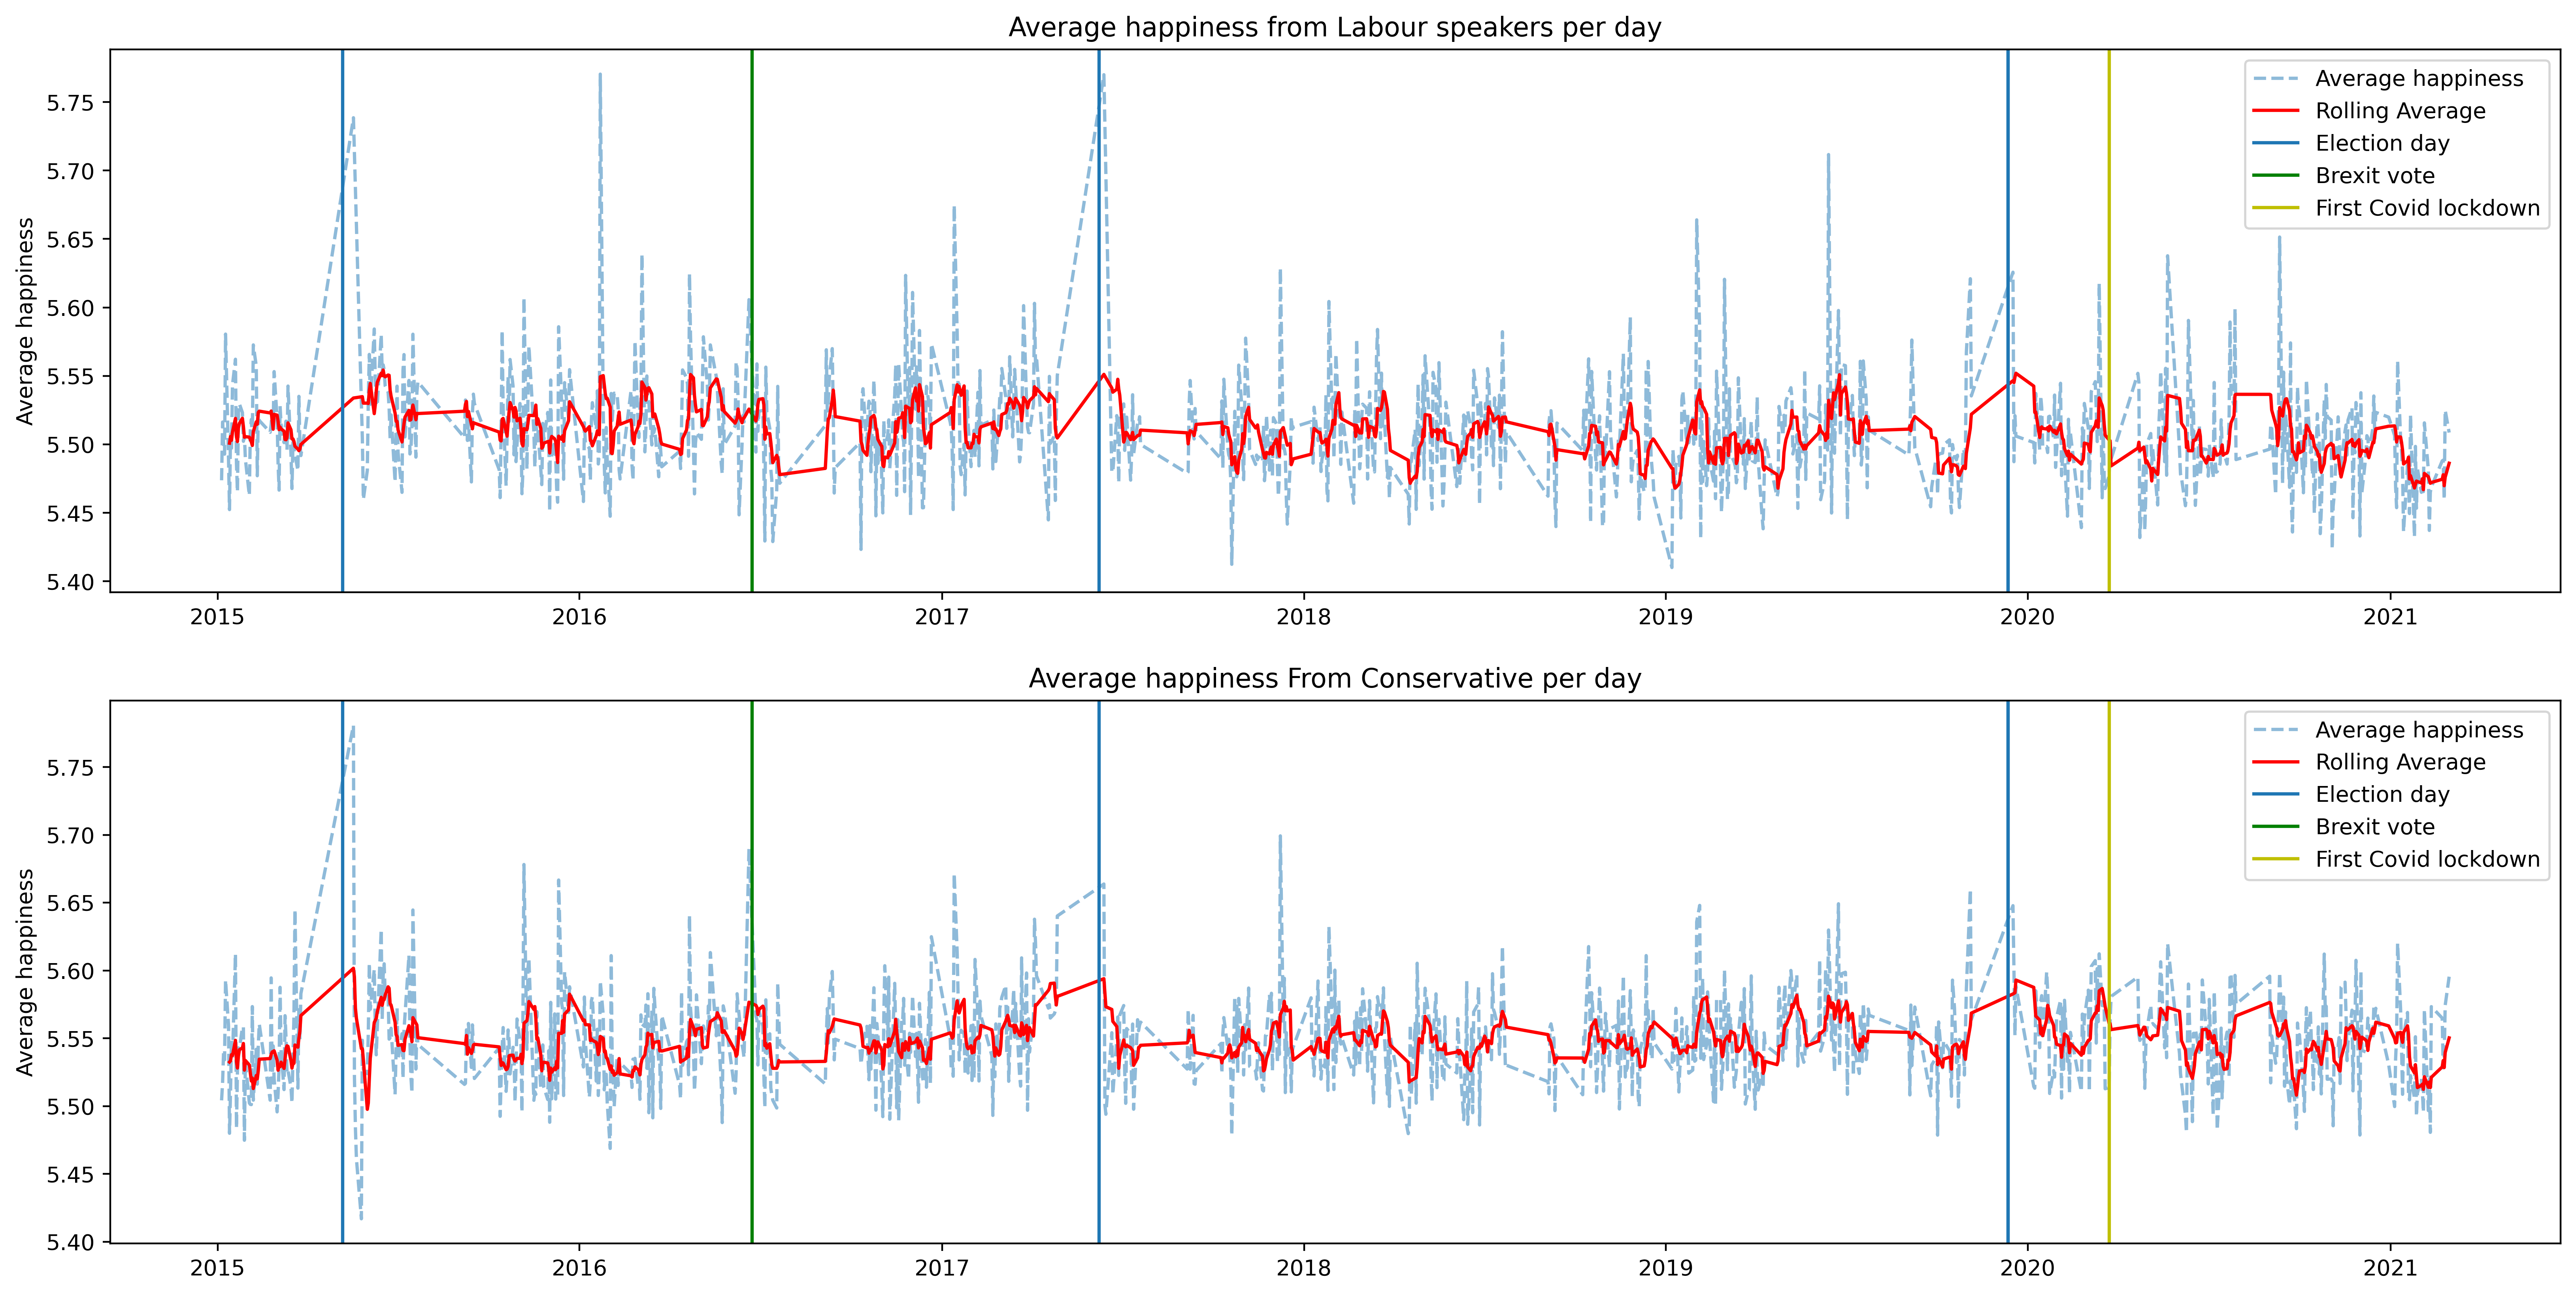

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10), dpi=400)
rolled_series = token_pr_date_labour["daily_happiness"].rolling(7).mean()
ax1.plot(token_pr_date_labour.index, token_pr_date_labour["daily_happiness"], ls = "--", alpha = 0.5, label='Average happiness')
ax1.plot(rolled_series.index, rolled_series.values, color = "r", label='Rolling Average')
for idx in range(len(election_days)):
    ax1.axvline(election_days[idx])
ax1.axvline(election_days[-1], label = "Election day")
ax1.axvline(brexit_vote, label = "Brexit vote", color = "g")
ax1.axvline(covid_lockdown, color = "y", label = "First Covid lockdown")
ax1.set_title("Average happiness from Labour speakers per day")
ax1.set_ylabel("Average happiness")
ax1.legend()

rolled_series2 = token_pr_date_conservative["daily_happiness"].rolling(7).mean()
ax2.plot(token_pr_date_conservative.index, token_pr_date_conservative["daily_happiness"], ls = "--", alpha = 0.5, label='Average happiness')
ax2.plot(rolled_series2.index, rolled_series2.values, color = "r", label='Rolling Average')
for idx in range(len(election_days)):
    ax2.axvline(election_days[idx])
ax2.axvline(election_days[-1], label = "Election day")
ax2.axvline(brexit_vote, label = "Brexit vote", color = "g")
ax2.axvline(covid_lockdown, color = "y", label = "First Covid lockdown")
ax2.set_title("Average happiness From Conservative per day")
ax2.set_ylabel("Average happiness")
ax2.legend()
fig.savefig("happiness_scores.pdf")
plt.show()

Plot need some more work

In [15]:
mean_labour_happiness = np.mean(token_pr_date_labour["daily_happiness"].values)
mean_conservative_happiness = np.mean(token_pr_date_conservative["daily_happiness"].values)
print(f"Mean Labour happiness score: {mean_labour_happiness}")
print(f"Mean Conservative happiness score: {mean_conservative_happiness}")

Mean Labour happiness score: 5.508579469270198
Mean Conservative happiness score: 5.5480341116436005


In [20]:
token_pr_date_labour["daily_happiness"].corr(token_pr_date_conservative["daily_happiness"])

0.5950086078205029

As seen from the plots and the mean happiness score for each party there are no great fluctuations, either overtime or between the two parties. This is mainly attributed to the text being in a highly formal setting and the words are chosen reflect that. Since most MP make use of this language, though they highly disagree on topics, it pushes the sentiment score towards the neutral 5. It is interesting, however, that the sentiment score is still above 5 in this setting, again showing support for the *Pollyanna hypothesis*.

A correlation of 0.595 between the happiness scores for each party indicates that the sentiment in the parliament follows at some level the same tendencies. This makes sense since there is a natural linkage between the topics addressed by MP in the chronological order the data is presented. Many topics of bills discussed in the house poses a problem where parties differ on which solution is most appropriate.

### Wordshifts

In the following section, the wordshifts for both the Conservative and Labour party will be explored. 

Originally this part of the analysis was intended for the Party status attribute (Coalition, Opposition), as it was hypothesised to yield a more distinctive separation of central word use related to the sentiment around certain events. Instead, two major parties were chosen.

As a major event the first COVID lockdown in UK was chosen. To create the wordshifts two lists are defined, one containing all the words say that day in a single document and a reference list that looks back in time.



In [4]:
max_h = token_pr_date_conservative["daily_happiness"].max()
date_max_h = pd.to_datetime("2020-03-23").date() # first COVID lockdown
d_max = date_max_h - timedelta(days = 14) # 7 days before as reference

In [5]:
temp = token_pr_date_labour[((token_pr_date_labour.index <= date_max_h) & (token_pr_date_labour.index >= d_max))]
temp

,document,daily_happiness
date,,
2020-03-09,"['inform', 'house', 'calling', 'question', 'le...",5.545806
2020-03-10,"['plans', 'publish', 'local', 'authority', 'pu...",5.526040
2020-03-11,"['house', 'wish', 'know', 'secretary', 'state'...",5.502045
2020-03-12,"['steps', 'taking', 'reduce', 'cost', 'rail', ...",5.507387
2020-03-13,"['beg', 'move', 'bill', 'read', 'second', 'tim...",5.617621
2020-03-16,"['notify', 'house', 'accordance', 'royal', 'as...",5.460972
2020-03-17,"['steps', 'taking', 'support', 'uk', 'national...",5.515345
2020-03-18,"['assessment', 'made', 'effect', 'budget', 'no...",5.476089
2020-03-19,"['government', 'plan', 'implement', 'commitmen...",5.467750


In [6]:
import ast
l = ast.literal_eval(token_pr_date_labour["document"].loc[date_max_h])
#l_ref = np.concatenate(token_pr_date_labour["document"][((token_pr_date_labour.index <= date_max_h) & (token_pr_date_labour.index >= d_max))].values).tolist()
l_ref = token_pr_date_labour["document"][((token_pr_date_labour.index <= date_max_h) & (token_pr_date_labour.index >= d_max))].values
l_ref = list(itertools.chain.from_iterable([ast.literal_eval(x) for x in l_ref]))


In [7]:
p = dict([(item[0], item[1]/len(l)) for item in Counter(l).items()])
p_ref = dict([(item[0], item[1]/len(l_ref)) for item in Counter(l_ref).items()])

print(f"{dict(itertools.islice(p.items(), 5))}")
print(f"\n{dict(itertools.islice(p_ref.items(), 5))}")

{'yesterday': 0.00015246226558926666, 'march': 0.00038115566397316664, 'marked': 7.623113279463333e-05, 'third': 0.0003049245311785333, 'anniversary': 0.00015246226558926666}

{'inform': 5.139439415645739e-05, 'house': 0.0035140917004477736, 'calling': 0.00017345608027804368, 'question': 0.0010600093794769336, 'leave': 0.0005974598320688171}


In [8]:
# Top 10 word used for the given day.
sorted(p.items(), key = lambda x: x[1], reverse = True)[:10]

[('government', 0.013264217106266199),
 ('people', 0.012883061442293033),
 ('hon', 0.006937033084311633),
 ('need', 0.006937033084311633),
 ('would', 0.0068608019515169994),
 ('house', 0.006479646287543833),
 ('bill', 0.0064034151547491995),
 ('right', 0.006022259490776033),
 ('minister', 0.0059460283579814),
 ('care', 0.005336179295624333)]

In [9]:
# Top 10 word used for the reference days.
sorted(p_ref.items(), key = lambda x: x[1], reverse = True)[:10]

[('government', 0.011313191013690181),
 ('people', 0.009655721802144432),
 ('would', 0.005415684284236697),
 ('minister', 0.0053899870871584685),
 ('need', 0.00536428989008024),
 ('many', 0.004683314167507179),
 ('hon', 0.004246461817177291),
 ('support', 0.004085854335438362),
 ('also', 0.0038288823646560753),
 ('one', 0.0038031851675778463)]

In [10]:
all_tokens = set(p.keys()).union(set(p_ref.keys())) # Set of the tokens that exist in both p and p_ref.
# dp show the difference between the two lists.
dp = dict([(token, p.get(token, 0) - p_ref.get(token, 0)) for token in all_tokens])
print(f"{dict(itertools.islice(dp.items(), 5))}")

{'sanguine': -6.4242992695571735e-06, 'normally': -0.00011563738685202912, 'macron': -1.9272897808671518e-05, 'siren': -6.4242992695571735e-06, 'careworkers': -7.2847577096099195e-06}


In [11]:
#print top10
sorted(dp.items(), key = lambda x: x[1], reverse = True)[0:10]

[('people', 0.0032273396401486017),
 ('bill', 0.003184841220701056),
 ('measures', 0.003178074109303988),
 ('house', 0.0029655545870960593),
 ('hon', 0.0026905712671343417),
 ('right', 0.002604532279371617),
 ('staff', 0.0024637153417539012),
 ('workers', 0.0023279445986531476),
 ('must', 0.0020692517109907552),
 ('powers', 0.0020273806377365546)]

In [14]:
labMT_dict = dict(zip(labMT["Word"].values, labMT["Happiness Score"].values))
# Compute happiness for each word where all scores are shifted by -5
h = dict([(token, labMT_dict.get(token, np.nan) - 5) for token in all_tokens])

In [15]:
# Compute the product of delta p and h
dPhi = [(token, h[token] * dp[token]) for token in all_tokens if not np.isnan(h[token])]

In [16]:
# dPhi are the words that contributes most in the shifting of the happiness scores. 
sorted(dPhi, key = lambda x:np.abs(x[1]), reverse=True)[:10]

[('noble', -0.005808485276181414),
 ('women', -0.005556761896196173),
 ('bill', -0.004331384060153436),
 ('lord', -0.004070158887867544),
 ('right', 0.00401097971023229),
 ('house', 0.003973843146708719),
 ('people', 0.0037437139825723786),
 ('death', -0.003531085171858199),
 ('emergency', -0.003388856945273945),
 ('powers', 0.003365451858642681)]

C:\Users\Daniel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\shifterator\plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


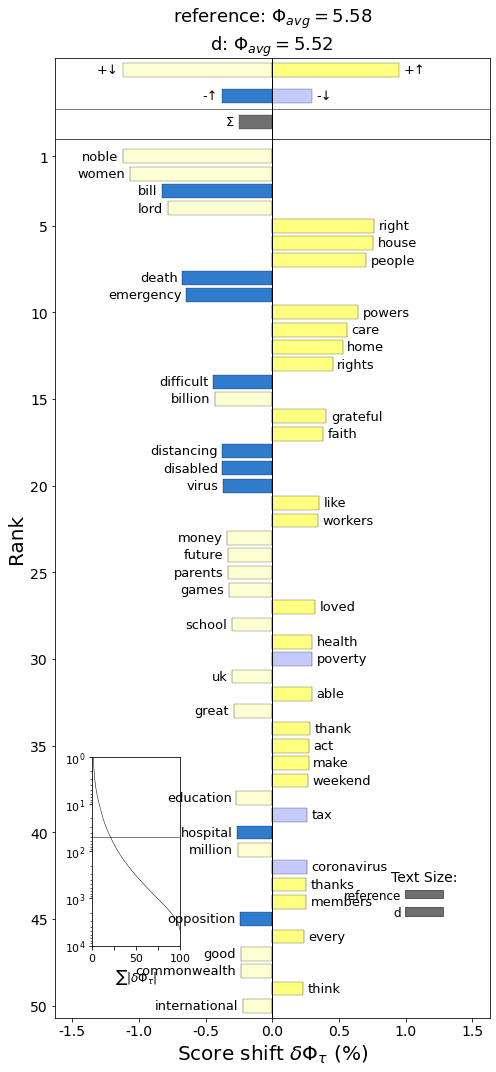

<AxesSubplot:title={'center':'reference: $\\Phi_{avg}=$5.58\nd: $\\Phi_{avg}=$5.52'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [17]:
import shifterator as sh
sentiment_sh = sh.WeightedAvgShift(type2freq_1 = p_ref, type2freq_2 = p, type2score_1 = labMT_dict, reference_value = 5)
sentiment_sh.get_shift_graph(detailed = True, system_names = ["reference", "d"])

Now the same procedure is used for the Conservative Party.

In [18]:
# For the Conservative party
l = ast.literal_eval(token_pr_date_conservative["document"].loc[date_max_h])
#l_ref = np.concatenate(token_pr_date_labour["document"][((token_pr_date_labour.index <= date_max_h) & (token_pr_date_labour.index >= d_max))].values).tolist()
l_ref = token_pr_date_conservative["document"][((token_pr_date_conservative.index <= date_max_h) & (token_pr_date_conservative.index >= d_max))].values
l_ref = list(itertools.chain.from_iterable([ast.literal_eval(x) for x in l_ref]))
p = dict([(item[0], item[1]/len(l)) for item in Counter(l).items()])
p_ref = dict([(item[0], item[1]/len(l_ref)) for item in Counter(l_ref).items()])

print(f"{dict(itertools.islice(p.items(), 5))}")
print(f"\n{dict(itertools.islice(p_ref.items(), 5))}")

{'plans': 0.000250857095074839, 'mark': 8.361903169161301e-05, 'conclusion': 0.0007525712852245171, 'initial': 4.1809515845806506e-05, 'term': 0.00016723806338322602}

{'recent': 0.0003900756174109715, 'assessment': 0.0001717764186763911, 'made': 0.0029309351436659233, 'trends': 2.147205233454889e-05, 'number': 0.0015996678989238923}


In [19]:
# Top 10 word used for the given day.
sorted(p.items(), key = lambda x: x[1], reverse = True)[:10]

[('hon', 0.010786855088218078),
 ('government', 0.01015971235053098),
 ('right', 0.008403712685007107),
 ('bill', 0.0076093318839367844),
 ('house', 0.006480474956100008),
 ('people', 0.006313236892716782),
 ('friend', 0.005811522702567104),
 ('need', 0.005644284639183878),
 ('would', 0.005226189480725813),
 ('new', 0.004766284806421941)]

In [20]:
# Top 10 word used for the reference days.
sorted(p_ref.items(), key = lambda x: x[1], reverse = True)[:10]

[('hon', 0.009283083959303303),
 ('government', 0.0077299388404376),
 ('people', 0.007035675814953853),
 ('right', 0.006577605365150143),
 ('friend', 0.006380778218750112),
 ('noble', 0.00541095718830632),
 ('would', 0.004795425021382586),
 ('support', 0.004437557482473437),
 ('also', 0.0041369487497897525),
 ('need', 0.004029588488117008)]

In [21]:
all_tokens = set(p.keys()).union(set(p_ref.keys())) # Set of the tokens that exist in both p and p_ref.
# dp show the difference between the two lists.
dp = dict([(token, p.get(token, 0) - p_ref.get(token, 0)) for token in all_tokens])
print(f"{dict(itertools.islice(dp.items(), 5))}")
labMT_dict = dict(zip(labMT["Word"].values, labMT["Happiness Score"].values))
# Compute happiness for each word where all scores are shifted by -5
h = dict([(token, labMT_dict.get(token, np.nan) - 5) for token in all_tokens])
# Compute the product of delta p and h
dPhi = [(token, h[token] * dp[token]) for token in all_tokens if not np.isnan(h[token])]
# dPhi are the words that contributes most in the shifting of the happiness scores. 
sorted(dPhi, key = lambda x:np.abs(x[1]), reverse=True)[:10]

{'siren': -3.578675389091482e-06, 'defraud': -3.578675389091482e-06, 'parris': -7.157350778182964e-06, 'porters': -3.578675389091482e-06, 'norway': -7.157350778182964e-06}


[('bill', -0.00628474759030174),
 ('noble', -0.005972010538499086),
 ('powers', 0.005361482445431507),
 ('coronavirus', -0.004195842758404184),
 ('care', 0.004154860308883938),
 ('health', 0.003995995253665583),
 ('women', -0.003841321991691592),
 ('house', 0.003413664342674549),
 ('act', 0.0033513985299882974),
 ('lord', -0.0029912874048966752)]

C:\Users\Daniel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\shifterator\plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


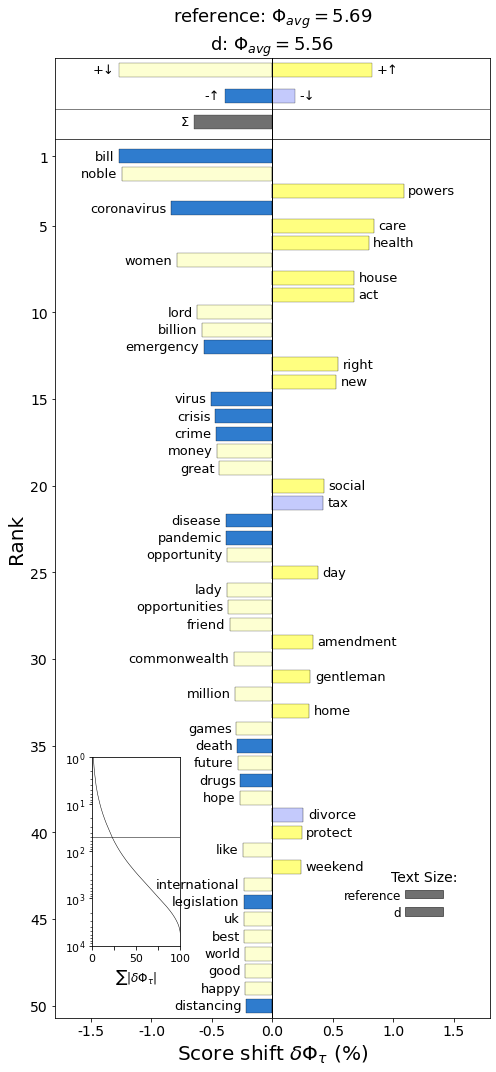

<AxesSubplot:title={'center':'reference: $\\Phi_{avg}=$5.69\nd: $\\Phi_{avg}=$5.56'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [22]:
import shifterator as sh
sentiment_sh = sh.WeightedAvgShift(type2freq_1 = p_ref, type2freq_2 = p, type2score_1 = labMT_dict, reference_value = 5)
sentiment_sh.get_shift_graph(detailed = True, system_names = ["reference", "d"])